In [ ]:
import pandas as pd
import numpy as np
from Indicator import DataManage
from Labeling import Labeling
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

In [91]:
class backtest:
    def __init__(self,data, initbalance = 10000,fee = 0.0004, max_buy = 1000, set_amount = 2, model = None, result_label = None, test_size = 1440):
        """
        data(DataFrame) : ex) Include close price

        result_label(list) : ex) [-1,0,0,1,-1,....] (-1,0,1)만 포함

        test_size(int) : ex) 1440 * 30

        set_amount(float) : ex) 0.02

        fee(float) : ex) fee == 0.08% -> 0.0008

        max_buy(int) : ex) 10000 
        """
        self.data = data # 주가 데이터
        self.result_label = result_label # 머신러닝의 예측값
        self.test_size = test_size # 테스트 데이터의 길이
        self.set_amount = set_amount # 한번 매수할때 금액(달러)
        self.fee = fee # 한번 거래 할 때 수수료
        self.max_buy = max_buy # 최대 누적 매수금액

        # 손절형 순환매매에서 사용하는 변수
        self.buy_flag = 0
        self.sell_flag = 0

        # 공통 사용 변수
        self.initbalance = initbalance
        self.quantityBuying = 0 # 현재 매수 수량
        self.BuyingList = [] # 현재 매수 했던 가격들의 리스트
        self.totalYield = 0 # 최종 수익률
        self.totalNumberSales = 0 # 총 매도 횟수
        self.win = 0
        self.quantityBuyingList = [] # 매수 수량을 저장하는 리스트
        self.amount = 0 # 현재 가지고 있는 주식 수량
        self.MDDList = [] # MDD를 계산하기 위한 리스트
        self.average_price = 0 # 평단가
        self.balance = initbalance
        # 머신러닝 모델
        self.model = model
    def initializes(self):
        self.buy_flag = 0
        self.sell_flag = 0

        # 공통 사용 변수
        self.quantityBuying = 0
        self.BuyingList = []
        self.totalYield = 0
        self.totalNumberSales = 0
        self.win = 0
        self.quantityBuyingList = []
        self.amount = 0
        self.MDDList = []
        self.average_price = 0

    def SellInitializes(self,currYield):
        if currYield > 0:
            self.win += 1
        self.average_price = 0
        self.totalNumberSales += 1
        self.totalYield += currYield
        self.amount = 0
        self.BuyingList.clear()
        self.quantityBuying = 0
        self.buy_flag = 0
        self.sell_flag = 0
        
    def PricePredictionStrategy(self):
        self.initializes()
        split_sid = 3
        flag = True
        for i in tqdm(range(len(self.data))):

            self.set_amount = self.balance / (split_sid - self.quantityBuying)
            curr_data = self.data.iloc[i]
            pred = self.result_label[i]

            # 시드 3분할 투입 3% 익절 -1.5%시 추매 혹은 손절
            # 그리고 시그널이 매도 시그널로 바뀌어도 바로 손절 
            if pred == 4 or pred == 3:
                if self.quantityBuying < split_sid and flag == True:
                    self.quantityBuying += 1
                    self.average_price = ( self.average_price * self.amount + self.data.iloc[i]['close'] * self.set_amount) / (self.amount + self.set_amount)
                    self.amount += self.set_amount
                    self.BuyingList.append(self.data.iloc[i]['close'])
                    flag = False
            
            if pred == 0 or pred == 1:
                currYield = (self.data.iloc[i]['close']-self.average_price) * self.amount - (self.average_price * self.fee * self.amount)
                self.quantityBuyingList.append(self.quantityBuying)

                self.SellInitializes(currYield)
                flag = True

            if self.average_price > 0:
                # 익절
                if (curr_data["close"] - self.average_price) / self.average_price > 0.03:
                    currYield = (self.data.iloc[i]['close']-self.average_price) * self.amount - (self.average_price * self.fee * self.amount)
                    self.quantityBuyingList.append(self.quantityBuying)

                    self.SellInitializes(currYield)
                    flag = True

                # 추가 매수
                if (curr_data["close"] - self.average_price) / self.average_price < -0.015 and flag == False and self.quantityBuying < split_sid:
                    self.quantityBuying += 1
                    self.average_price = ( self.average_price * self.amount + self.data.iloc[i]['close'] * self.set_amount) / (self.amount + self.set_amount)
                    self.amount += self.set_amount
                    self.BuyingList.append(self.data.iloc[i]['close'])

                # 손절
                if (curr_data["close"] - self.average_price) / self.average_price < -0.015 and self.quantityBuying == split_sid:
                    currYield = (self.data.iloc[i]['close']-self.average_price) * self.amount - (self.average_price * self.fee * self.amount)
                    self.quantityBuyingList.append(self.quantityBuying)

                    self.SellInitializes(currYield)
                    flag = True
        if len(self.quantityBuyingList) == 0 or self.totalNumberSales == 0:
            print("Zero DivisionError")
            raise ZeroDivisionError
        return {
            "averageNumberSales" : sum(self.quantityBuyingList)/len(self.quantityBuyingList),
            "totalYield" : self.totalYield,
            "win_rate" : self.win/self.totalNumberSales,
            "max_buying" : self.quantityBuyingList[-1],
            "NumberTrading" : self.totalNumberSales
        }


In [111]:
class Labeling:
    def __init__(self, data, term):
        self.data = data
        self.term = term
        self.labeled = []
    def ck1(self, i):
        for j in range(i,i+self.term):
            curr_diff = self.data.iloc[i + j]["close"] - self.data.iloc[i]["close"]
            persent = int(round(curr_diff/self.data.iloc[i]["close"] * 100, 0))
            if persent < -1.5:
                return True
        return False
    def ck2(self, i):
        for j in range(i,i+self.term):
            curr_diff = self.data.iloc[i + j]["close"] - self.data.iloc[i]["close"]
            persent = int(round(curr_diff/self.data.iloc[i]["close"] * 100, 0))
            if persent > 3.0:
                return True
        return False
    def run(self):
        for i in tqdm(range(0, len(self.data) - self.term)):
            curr_diff = self.data.iloc[i + self.term]["close"] - self.data.iloc[i]["close"]
            persent = int(round(curr_diff/self.data.iloc[i]["close"] * 100, 0))
            
            if persent < -1.5 and not self.ck2(i):
                self.labeled.append(0)
            elif persent >= 3.0 and not self.ck1(i):
                self.labeled.append(1)
            else:
                self.labeled.append(2)
        return self.labeled

In [ ]:
def Data_StandardScaler(data):
    scaler = StandardScaler()
    scaler.fit(data)
    scalering_data = scaler.transform(data)
    scalering_data = pd.DataFrame(data = scalering_data, columns=data.columns)
    return scalering_data

In [109]:
data = pd.read_csv("BTC_USDT_1m.csv",index_col=0)
data.head()

,datetime,open,high,low,close,volume
0,2017-12-31 15:00:00,13328.28,13337.94,13306.01,13320.00,6.968367
1,2017-12-31 15:01:00,13320.00,13337.94,13300.00,13313.30,14.857871
2,2017-12-31 15:02:00,13313.30,13313.30,13280.00,13305.01,10.268893
3,2017-12-31 15:03:00,13313.30,13334.00,13301.27,13334.00,12.516135
4,2017-12-31 15:04:00,13314.00,13346.60,13310.02,13325.01,13.362592


In [112]:
Labeled = Labeling(data, 120).run()
Labeled.head()

  0%|          | 12218/2713268 [00:58<3:36:35, 207.85it/s]


KeyboardInterrupt: 

In [102]:
data = data.iloc[120:]
data.loc[:, "label"] = Labeled
data.head()

,datetime,open,high,low,close,volume,label
120,2017-12-31 17:00:00,13831.01,13836.00,13730.00,13817.77,25.885158,4
121,2017-12-31 17:01:00,13810.00,13817.80,13720.00,13800.02,21.800929,4
122,2017-12-31 17:02:00,13800.02,13800.02,13676.75,13765.34,18.382567,4
123,2017-12-31 17:03:00,13740.13,13749.99,13701.00,13740.00,17.052272,4
124,2017-12-31 17:04:00,13740.00,13799.00,13713.48,13755.01,22.326130,4


In [104]:
data.iloc[0]["close"], data.iloc[120]["close"]

(13817.77, 13748.0)

In [107]:
(data.iloc[240]["close"] - data.iloc[120]["close"]) / data.iloc[0]["close"] * 100

1.4822941762672248

In [54]:
term = 120
parameter = [
        {"rsi" : {"period" : term}},
        {"ma" : {"period" : term}},
        {"ema" :{"period" : term}},
        {"stochastic" : {"n" : term,"m" : 5,"t" : 5}},
        {"bb" : {"length" : term,"std" : 2}},
        {"kdj" : {}},
        {"macd" : {"fast_period": int(term/2), "slow_period" : term}}
]
data = DataManage(data,parameter).get_data()
data.head()

,datetime,open,high,low,close,volume,label,rsi_120,mean_120,ema_120,...,fast_d,slow_k,slow_d,BBL,BBM,BBU,BBP,K_9_3,D_9_3,J_9_3
240,2017-12-31 19:00:00,13745.00,13748.00,13745.00,13748.00,3.385922,0,47.950745,13794.331250,13794.137251,...,35.458490,35.458490,38.355888,13709.166195,13709.166195,13709.166195,13709.166195,35.474110,39.936683,26.548964
241,2017-12-31 19:01:00,13748.00,13765.05,13745.00,13765.05,6.792875,2,48.603011,13794.039833,13793.656470,...,37.020225,37.020225,37.910667,13708.715465,13708.715465,13708.715465,13708.715465,43.216936,41.030100,47.590606
242,2017-12-31 19:02:00,13765.05,13775.00,13765.05,13765.05,2.562485,2,48.603011,13794.037417,13793.183635,...,38.061381,38.061381,37.960905,13708.709780,13708.709780,13708.709780,13708.709780,48.381132,43.480444,58.182508
243,2017-12-31 19:03:00,13765.05,13780.00,13754.69,13768.90,9.668071,2,48.750482,13794.278250,13792.782253,...,39.170817,39.170817,38.364209,13709.400092,13709.400092,13709.400092,13709.400092,59.862526,48.941138,81.705301
244,2017-12-31 19:04:00,13768.90,13790.00,13745.00,13766.00,7.144261,2,48.644466,13794.369833,13792.339571,...,39.597594,39.597594,38.775337,13709.637764,13709.637764,13709.637764,13709.637764,62.522134,53.468137,80.630129


In [55]:
test_size = 1440 * 30
data = data.drop(["datetime"],axis=1)
X = Data_StandardScaler(data.drop(["label"],axis = 1))
Y = to_categorical(data.label.to_numpy())
x_train = X[:-test_size]
x_test = X[-test_size:]
y_train = Y[:-test_size]
y_test = Y[-test_size:]

In [59]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(256,input_shape = (x_train.shape[1],)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128,activation="sigmoid"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(256,activation="sigmoid"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(512,activation="sigmoid"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(256,activation="sigmoid"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128,activation="sigmoid"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32,activation="sigmoid"))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(5,activation="softmax"))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics=["accuracy"],
                    loss = tf.keras.losses.CategoricalCrossentropy())

In [60]:
history = model.fit(x_train,y_train, epochs=1,batch_size=16)

166872/166872 [==============================] - 427s 3ms/step - loss: 0.5539 - accuracy: 0.7582


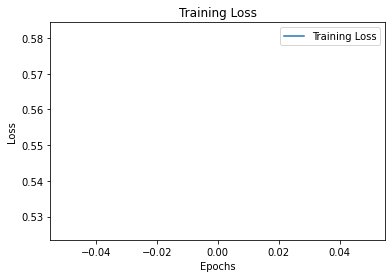

In [61]:
# loss 그래프 그리기
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
from sklearn.metrics import classification_report
y_test = np.argmax(y_test,axis = 1)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.90      0.59      5465
           2       0.92      0.73      0.82     32232
           4       0.64      0.71      0.67      5503

    accuracy                           0.75     43200
   macro avg       0.66      0.78      0.69     43200
weighted avg       0.82      0.75      0.77     43200



In [92]:
bot = backtest(data.drop(["label"],axis=1).iloc[-test_size:], result_label=y_pred)
bot.PricePredictionStrategy()

 38%|███▊      | 16333/43200 [00:01<00:01, 15916.60it/s]/var/folders/5v/ywkv8vl52zs0xz8k0x15y8fm0000gn/T/ipykernel_33835/383780141.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  if (curr_data["close"] - self.average_price) / self.average_price < -0.015 and flag == False and self.quantityBuying < split_sid:
/var/folders/5v/ywkv8vl52zs0xz8k0x15y8fm0000gn/T/ipykernel_33835/383780141.py:112: RuntimeWarning: divide by zero encountered in double_scalars
  if (curr_data["close"] - self.average_price) / self.average_price < -0.015 and self.quantityBuying == split_sid:
100%|██████████| 43200/43200 [00:02<00:00, 15361.58it/s]


{'averageNumberSales': 0.008416017009213324,
 'totalYield': -3199444.5466667353,
 'win_rate': 0.002126151665485471,
 'max_buying': 0,
 'NumberTrading': 11288}

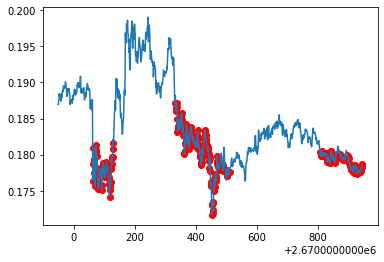

In [100]:

plt.plot(x_test.iloc[:1000].close)
for i in range(len(y_pred[:1000])):
    if y_pred[i] == 4:
        plt.scatter(x_test.index[i],x_test.iloc[i]["close"],color = "r")